# Modelisation de la consommation totale d'energie

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.preprocessing as sk_prepro
from sklearn import metrics

In [2]:
df = pd.read_csv('data_full.csv')

In [3]:
data_num = df
target_tag ='GHGEmissionsIntensity'
target = data_num[target_tag]
sqf = data_num['PropertyGFATotal']
data_num = data_num.drop(labels = [target_tag,'SiteEnergyUse(kBtu)', 'ENERGYSTARScore','SiteEUI(kBtu/sf)', 'TotalGHGEmissions' ], axis = 1)

In [4]:
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Columns: 522 entries, 0 to ThirdLargestPropertyUseTypeGFA
dtypes: float64(522)
memory usage: 6.5 MB


## Modèle linéaire

In [5]:
from sklearn.linear_model import Ridge
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor

In [6]:
from sklearn import linear_model
line_reg = linear_model.LinearRegression()

In [7]:
#first let's test this on knregressoe
xtrain, xtest, ytrain, ytest, sqftrain, sqftest = train_test_split(data_num, target, sqf, test_size = 0.2)

#let's standard scale

sscaler = sk_prepro.StandardScaler()
sscaler_fit = sscaler.fit(xtrain)
xtrain = sscaler_fit.transform(xtrain)
xtest = sscaler_fit.transform(xtest)
#log scale the target
ytrain = np.log(ytrain)
ytest = np.log(ytest)

sqftrain = np.array(sqftrain).reshape(-1,1)
sqftest = np.array(sqftest).reshape(-1,1)

In [8]:
def true_pred_plot(y_train,pred_train, y_test, pred_test):
    fig, ax = plt.subplots(2, figsize = (10,10))
    
    y_train= np.array(np.exp(y_train)).reshape(-1,1)
    pred_train = np.array(np.exp(pred_train)).reshape(-1,1)
    y_test = np.array(np.exp(y_test)).reshape(-1,1)
    pred_test = np.array(np.exp(pred_test)).reshape(-1,1)
    
    
    
    y_train = y_train*sqftrain
    pred_train = pred_train*sqftrain
    
    line_reg_train = line_reg.fit(pred_train,y_train)
    r2_train = line_reg_train.score(pred_train,y_train)
    rmse_train = (np.sqrt(metrics.mean_squared_error(y_train, pred_train))/np.mean(y_train))
    a = float(line_reg_train.coef_)
    b= line_reg_train.intercept_
    ax[0].scatter( y_train, pred_train)
    ax[0].plot([a*np.abs(b)+b, a*y_train.max()+b],[np.abs(b), ytrain.max()], linestyle = 'dashed')
    ax[0].text(0.7,0.4,'R2 : {:.3f} NRMSE : {: .2f}'.format(r2_train,rmse_train), transform = ax[0].transAxes)
    ax[0].set_xlabel('True values')
    ax[0].set_ylabel('Predicted values')
    ax[0].set_xlim(y_train.min(),y_train.max())
    ax[0].set_ylim(pred_train.min(),pred_train.max())
    ax[0].set_title('On train values')

    y_test = y_test*sqftest
    pred_test = pred_test*sqftest
    
    line_reg_test  = line_reg.fit(pred_test,y_test)
    r2_test =  line_reg_test.score(pred_test,y_test)
    rmse_test = (np.sqrt(metrics.mean_squared_error(y_test, pred_test))/np.mean(y_test))
    a = float(line_reg_test.coef_)
    b=  line_reg_test.intercept_
    ax[1].scatter( y_test, pred_test)
    ax[1].plot([a*np.abs(b)+b, a*y_test.max()+b],[np.abs(b), y_test.max()], linestyle = 'dashed')
    ax[1].text(0.7,0.4,'R2 : {:.3f} NRMSE : {: .2f}'.format(r2_test, rmse_test), transform = ax[1].transAxes)
    ax[1].set_xlabel('True values')
    ax[1].set_ylabel('Predicted values')
    ax[1].set_xlim(y_test.min(),y_test.max())
    ax[1].set_ylim(pred_test.min(),pred_test.max())
    ax[1].set_title('On test values')
    
    plt.show()
    plt.clf()

E:\temp\ipykernel_5108\760745115.py:7: RuntimeWarning: overflow encountered in exp
  pred_test = np.array(np.exp(pred_test)).reshape(-1,1)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

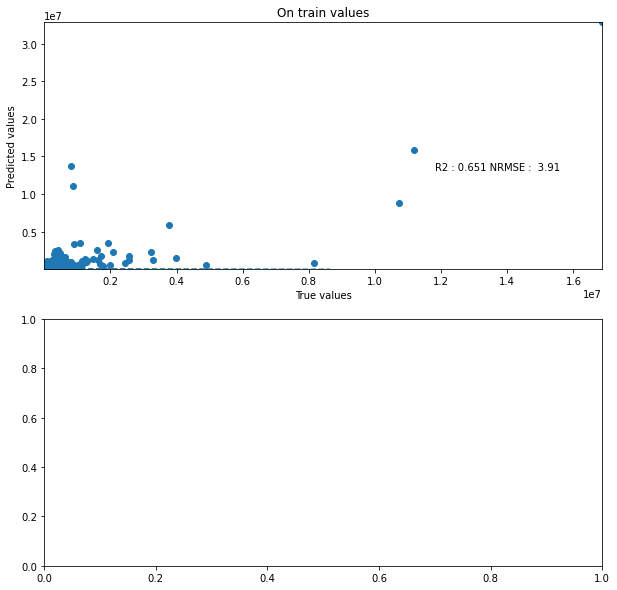

In [9]:
line_reg_m = linear_model.LinearRegression()

line_reg_m.fit(xtrain,ytrain)


true_pred_plot(ytrain, line_reg_m.predict(xtrain), ytest, line_reg_m.predict(xtest))

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best params on training set : {'n_neighbors': 9}
GridCV results : 
r2 = 0.006 (+/- 0.124) for {'n_neighbors': 2}
r2 = 0.099 (+/- 0.079) for {'n_neighbors': 3}
r2 = 0.149 (+/- 0.089) for {'n_neighbors': 4}
r2 = 0.154 (+/- 0.068) for {'n_neighbors': 5}
r2 = 0.168 (+/- 0.080) for {'n_neighbors': 6}
r2 = 0.178 (+/- 0.092) for {'n_neighbors': 7}
r2 = 0.179 (+/- 0.103) for {'n_neighbors': 8}
r2 = 0.181 (+/- 0.087) for {'n_neighbors': 9}
r2 = 0.177 (+/- 0.099) for {'n_neighbors': 10}
r2 = 0.168 (+/- 0.096) for {'n_neighbors': 11}
r2 = 0.164 (+/- 0.097) for {'n_neighbors': 12}
r2 = 0.149 (+/- 0.106) for {'n_neighbors': 13}
r2 = 0.137 (+/- 0.112) for {'n_neighbors': 14}
r2 = 0.133 (+/- 0.105) for {'n_neighbors': 15}


E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


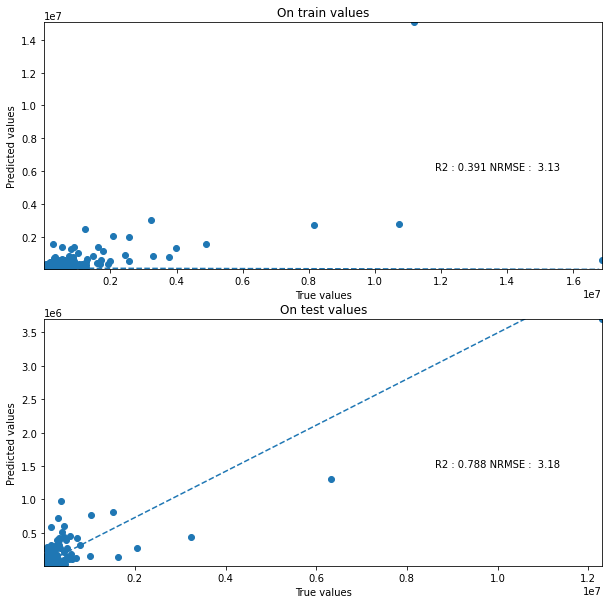

<Figure size 432x288 with 0 Axes>

In [10]:
#let's grid search for the k

k_grid = {'n_neighbors' : list(range(2,16))}
score = 'r2'

reg = GridSearchCV(KNeighborsRegressor(), k_grid, cv =3, scoring = score, verbose = 1)

reg.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(reg.best_params_))

print('GridCV results : ')
for mean, std, k in zip(reg.cv_results_['mean_test_score'],
                       reg.cv_results_['std_test_score'],
                       reg.cv_results_['params']):
    print('{} = {:.3f} (+/- {:.3f}) for {}'.format(score,mean,std*2,k))
    
model = KNeighborsRegressor(n_neighbors = reg.best_params_['n_neighbors']).fit(xtrain, ytrain)

true_pred_plot(ytrain, model.predict(xtrain), ytest, model.predict(xtest))

Do you want to launch ? [y/n] y


Fitting 3 folds for each of 120 candidates, totalling 360 fits
Best params on training set : {'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}


E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


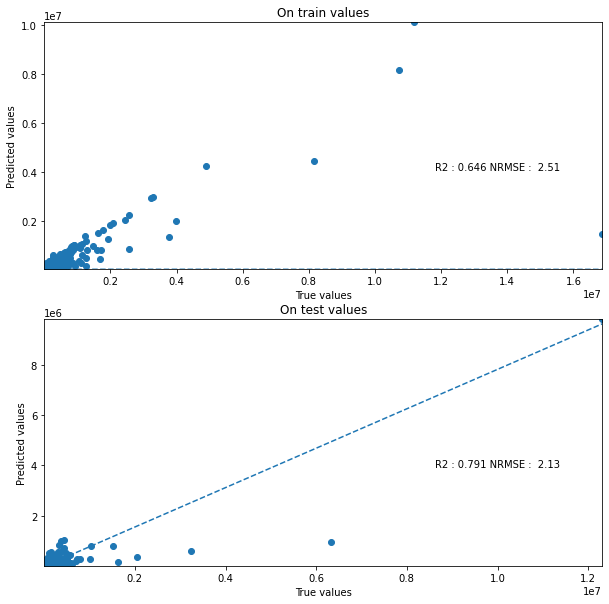

<Figure size 432x288 with 0 Axes>

In [11]:
x = input('Do you want to launch ? [y/n]')
if x == 'y':

    #let's try with a svr
    C_range = [1.0, 5.0, 10.0, 100.0]
    kernels = ['linear', 'rbf', 'sigmoid', 'poly']
    degrees = [2,3,4]
    gamma_range  = np.logspace(-2, 1, 10)
    #gamma_range = np.logspace(-2, 1, 10)
    #'gamma' : gamma_range
    param_grid = {'gamma' : gamma_range, 'kernel' : kernels, 'degree' : degrees}

    score = 'neg_mean_squared_error'

    svr_cv = GridSearchCV(svm.SVR(), param_grid, cv = 3, scoring = score, verbose = 1)

    svr_cv.fit(xtrain, ytrain)

    print('Best params on training set : {}'.format(svr_cv.best_params_))
bkernel = svr_cv.best_params_['kernel']
bgamma = svr_cv.best_params_['gamma']
bdegree = svr_cv.best_params_['degree']
    
svr = svm.SVR(kernel=bkernel, C=1.0, gamma = bgamma, degree = bdegree)
svr = svr.fit(xtrain,ytrain)

true_pred_plot(ytrain, svr.predict(xtrain), ytest, svr.predict(xtest))

In [ ]:
from sklearn import kernel_ridge
#let's try with a ridge regression

x = input('Do you want to launch ? [y/n]')
if x == 'y':
    alpha_range = [1.0, 5.0, 10.0, 100.0]
    kernels = ['linear', 'poly', 'sigmoid', 'rbf']
    degrees = [3,4,5]
    gamma_range  = np.logspace(-2, 1, 10)


    param_grid = {'gamma' : gamma_range, 'kernel' : kernels, 'degree' : degrees, 'alpha' : alpha_range}
    
    score = 'neg_mean_absolute_percentage_error'

    kernel_ridge_cv = GridSearchCV(kernel_ridge.KernelRidge(), param_grid, cv = 3, scoring = score, verbose = 1)

    kernel_ridge_cv.fit(xtrain, ytrain)

    print('Best params on training set : {}'.format(kernel_ridge_cv.best_params_))
    
bkernel = kernel_ridge_cv.best_params_['kernel']
bgamma = kernel_ridge_cv.best_params_['gamma']
bdegree = kernel_ridge_cv.best_params_['degree']
balpha = kernel_ridge_cv.best_params_['alpha']

model = kernel_ridge.KernelRidge(alpha = balpha, kernel = bkernel, degree = bdegree, gamma = bgamma)
model = model.fit(xtrain, ytrain)

true_pred_plot(ytrain, model.predict(xtrain), ytest, model.predict(xtest))

## Neural network

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#test with a single perceptron
model1 = keras.Sequential()
model1.add(keras.Input(shape = xtrain.shape[1]))
model1.add(layers.Dense(1,input_dim = 2, activation = 'linear'))

model1.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model1.summary()

history = model1.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

In [ ]:
true_pred_plot(ytrain, model1.predict(xtrain), ytest, model1.predict(xtest))

In [ ]:
model2 = keras.Sequential(
    [
        layers.Dense(xtrain.shape[1], activation="relu", name="layer1", input_shape=(xtrain.shape[1],), input_dim = 2),
        layers.Dense(287, activation="relu", name="layer2"),
        layers.Dense(1, activation = 'linear', name="layer3"),
    ]
)

model2.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model2.summary()

history2 = model2.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

In [ ]:
true_pred_plot(ytrain, model2.predict(xtrain), ytest, model2.predict(xtest))

In [ ]:
#now with a multi layer network

model3 = keras.Sequential(
    [
        layers.Dense(xtrain.shape[1], activation="relu", name="layer1", input_shape=(xtrain.shape[1],), input_dim = 2),
        layers.Dense(287, activation="relu", name="layer2b"),
        layers.Dense(82, activation="relu", name="layer3"),
        layers.Dense(20, activation="relu", name="layer4"),
        layers.Dense(4, activation = "relu", name = "layer5"),
        layers.Dense(1, activation = 'relu', name="layer6"),
    ]
)

model3.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model3.summary()

history3 = model3.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

In [ ]:
true_pred_plot(ytrain, model3.predict(xtrain), ytest, model3.predict(xtest))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=1000, verbose = 1)

model = rfr.fit(xtrain,ytrain)

true_pred_plot(ytrain, model.predict(xtrain), ytest, model.predict(xtest))

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators = 1000, verbose = 1)
model = gbr.fit(xtrain, ytrain)

true_pred_plot(ytrain, model.predict(xtrain), ytest, model.predict(xtest))

In [ ]:
importance = model.feature_importances_
nul_col = []
for i,v in enumerate(importance):
    if v == 0:
        nul_col.append(i)
print(nul_col)
# plot feature importance
fig, ax = plt.subplots(figsize = (20,20))
ax.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
#let's try to drop useless columns
label = []
for i in nul_col:
    label.append(data_num.columns[i])
data_test = data_num.drop(axis = 1, labels = label)

xtrain, xtest, ytrain, ytest, sqftrain, sqftest = train_test_split(data_num, target, sqf, test_size = 0.2)

#let's standard scale

sscaler = sk_prepro.StandardScaler()
sscaler_fit = sscaler.fit(xtrain)
xtrain = sscaler_fit.transform(xtrain)
xtest = sscaler_fit.transform(xtest)
#log scale the target
ytrain = np.log(ytrain)
ytest = np.log(ytest)

sqftrain = np.array(sqftrain).reshape(-1,1)
sqftest = np.array(sqftest).reshape(-1,1)

gbr = GradientBoostingRegressor(n_estimators = 500, verbose = 1)
model = gbr.fit(xtrain, ytrain)

true_pred_plot(ytrain, model.predict(xtrain), ytest, model.predict(xtest))